# Introduction

This project mainly focuses on finding the best fit model for analyzing Google Play Store apps. We collected the Google Play Store Apps dataset from Kaggle and used mainly the techniques that we learnt from machine learning lecture with necessary modification. Although the dataset is unbalanced, we evaluate the models not only with accuracy but also the F-measure to make it more reliable. Finally, we compared all of our results and concluded our model selections.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import random
import matplotlib.pyplot as plt
from pandas import read_csv
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.metrics import f1_score, precision_score, recall_score

df = pd.read_csv('googleplaystore1.csv',encoding='latin-1')
df.info()

C:\Users\Carol\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9298 entries, 0 to 9297
Data columns (total 13 columns):
App               9295 non-null object
Category          9295 non-null object
Rating            9295 non-null float64
Reviews           9295 non-null float64
Size              9295 non-null object
Installs          9295 non-null object
Type              9295 non-null object
Price             9295 non-null object
Content Rating    9295 non-null object
Genres            9295 non-null object
Last Updated      9295 non-null object
Current Ver       9291 non-null object
Android Ver       9293 non-null object
dtypes: float64(2), object(11)
memory usage: 944.4+ KB


## Data Cleaning and Normalization

In [2]:
df.dropna(inplace=True)
#drop missing value
df.dtypes

App                object
Category           object
Rating            float64
Reviews           float64
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [3]:
df.Size=df.Size.str.replace('k','e+3')
df.Size=df.Size.str.replace('M','e+6')
df.Size=df.Size.replace('Varies with device',np.nan)
df.Size=pd.to_numeric(df.Size)
#change M and k into values

df.Price=df.Price.apply(lambda x: x.strip('$'))
df.Price=df.Price.get_values()
df.Price=pd.to_numeric(df.Price)
#clean the $ from Price

df.Installs=df.Installs.apply(lambda x: x.strip('+'))
df.Installs=df.Installs.apply(lambda x: x.replace(',','')).get_values()
df.Installs=pd.to_numeric(df.Installs)
#clean the Installs

df['TypeEncode']=df.Type.map({'Free':0 , 'Paid':1})


bins = [0,0.9,2,3,4,5]
labels=[0,1,2,3,4]
df['RatingEncode'] = pd.cut(df['Rating'],bins=bins,labels=labels, include_lowest=True)

bins1 = [0,99,1000,10000,100000,1000000,10000000,80000000]
labels1=[0,1,2,3,4,5,6]
df['ReviewsEncode'] = pd.cut(df['Reviews'],bins=bins1,labels=labels1, include_lowest=True)

df.dtypes

App                 object
Category            object
Rating             float64
Reviews            float64
Size               float64
Installs             int64
Type                object
Price              float64
Content Rating      object
Genres              object
Last Updated        object
Current Ver         object
Android Ver         object
TypeEncode           int64
RatingEncode      category
ReviewsEncode     category
dtype: object

## Data exploration

### Rating

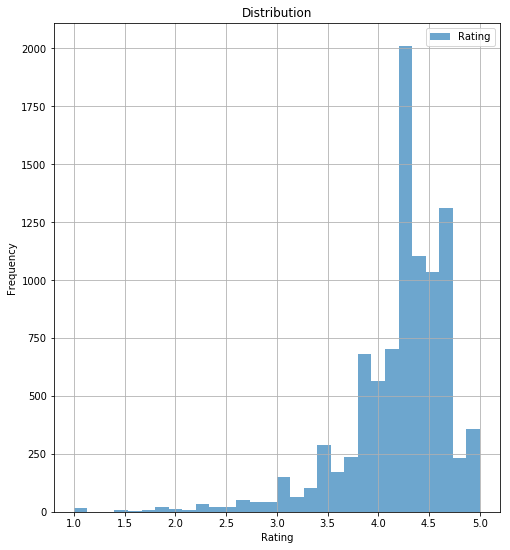

In [4]:
df["Rating"].plot(kind="hist",bins=30,grid=True,alpha=0.65,label="Rating",figsize=(8,9))
plt.legend()
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution")
plt.show()

### Price

Free    8666
Paid     623
Name: Type, dtype: int64


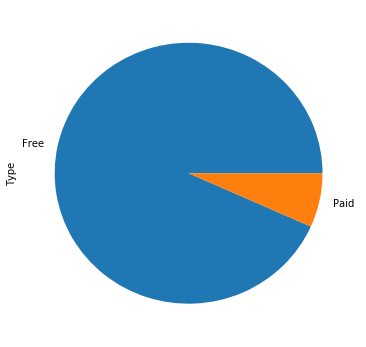

In [5]:
plt.figure(figsize=(6,6))
df.Type.value_counts().plot(kind="pie")
print(df.Type.value_counts())

## Finding correlations and important features

              Rating   Reviews      Size  Installs     Price  TypeEncode
Rating      1.000000  0.068045  0.084311  0.051314  0.019679    0.043006
Reviews     0.068045  1.000000  0.242144  0.641536 -0.024444   -0.042682
Size        0.084311  0.242144  1.000000  0.163921 -0.002509   -0.024583
Installs    0.051314  0.641536  0.163921  1.000000 -0.030107   -0.052403
Price       0.019679 -0.024444 -0.002509 -0.030107  1.000000    0.573899
TypeEncode  0.043006 -0.042682 -0.024583 -0.052403  0.573899    1.000000


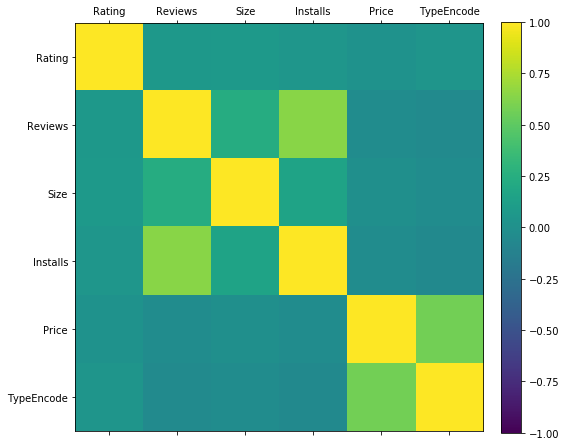

In [6]:
from pandas.plotting import scatter_matrix
print(df.corr())

names = ['Rating','Reviews','Size','Installs','Price','TypeEncode']
correlations = df.corr()

fig = plt.figure()
ax = fig.add_subplot(111)

cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax, fraction=0.046, pad=0.04)
fig.set_size_inches(8,8)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

### Rating

In [7]:
print(df.corrwith(df['Rating']).sort_values(ascending=False))
ml_model=smf.ols('Rating ~ Size+Reviews+Installs+TypeEncode+Price', df)
Fitting_results=ml_model.fit()
print(Fitting_results.summary().tables[1])
print('p-values are: \n', Fitting_results.pvalues)

Rating        1.000000
Size          0.084311
Reviews       0.068045
Installs      0.051314
TypeEncode    0.043006
Price         0.019679
dtype: float64
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1233      0.009    463.778      0.000       4.106       4.141
Size        1.625e-09   2.73e-10      5.956      0.000    1.09e-09    2.16e-09
Reviews     1.818e-08   4.31e-09      4.215      0.000    9.73e-09    2.66e-08
Installs    4.993e-11   1.58e-10      0.317      0.752   -2.59e-10    3.59e-10
TypeEncode     0.1111      0.029      3.850      0.000       0.055       0.168
Price         -0.0015      0.003     -0.458      0.647      -0.008       0.005
p-values are: 
 Intercept     0.000000e+00
Size          2.692694e-09
Reviews       2.527786e-05
Installs      7.515487e-01
TypeEncode    1.189505e-04
Price         6.466213e-01
dtype: float64


Arranging the importance from the most important to less important:  
Size, Reviews, TypeEncode, Price and Installs  
However, TypeEncode and Price is actually highly relevant to each other.  
Due to their correlationship, we cannot just conclude this as our final result.

### Installs

In [15]:
print(df.corrwith(df['Installs']).sort_values(ascending=False))
ml_model=smf.ols('Installs ~ Size+Reviews+TypeEncode+Rating+Price', df)
Fitting_results=ml_model.fit()
print(Fitting_results.summary().tables[1])
print('p-values are: \n', Fitting_results.pvalues)

Installs      1.000000
Reviews       0.641536
Size          0.163921
Rating        0.051314
Price        -0.030107
TypeEncode   -0.052403
dtype: float64
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.07e+06   3.48e+06      0.595      0.552   -4.74e+06    8.88e+06
Size           0.0271      0.020      1.368      0.171      -0.012       0.066
Reviews       16.7377      0.248     67.556      0.000      16.252      17.223
TypeEncode -3.768e+06   2.09e+06     -1.800      0.072   -7.87e+06    3.36e+05
Rating      2.623e+05   8.28e+05      0.317      0.752   -1.36e+06    1.89e+06
Price      -3912.4596    2.3e+05     -0.017      0.986   -4.55e+05    4.47e+05
p-values are: 
 Intercept     0.551554
Size          0.171427
Reviews       0.000000
TypeEncode    0.071919
Rating        0.751549
Price         0.986444
dtype: float64


reviews, size, rating

### Reviews

In [12]:
print(df.corrwith(df['Reviews']).sort_values(ascending=False))
ml_model=smf.ols('Reviews ~ Size+Price+Installs+TypeEncode+Rating', df)
Fitting_results=ml_model.fit()
print(Fitting_results.summary().tables[1])
print('p-values are: \n', Fitting_results.pvalues)

Reviews       1.000000
Installs      0.641536
Size          0.242144
Rating        0.068045
Price        -0.024444
TypeEncode   -0.042682
dtype: float64
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.739e+05   1.27e+05     -5.319      0.000   -9.22e+05   -4.26e+05
Size           0.0112      0.001     15.756      0.000       0.010       0.013
Price      -1822.5675   8407.887     -0.217      0.828   -1.83e+04    1.47e+04
Installs       0.0223      0.000     67.556      0.000       0.022       0.023
TypeEncode -8.833e+04   7.65e+04     -1.155      0.248   -2.38e+05    6.15e+04
Rating      1.274e+05   3.02e+04      4.215      0.000    6.81e+04    1.87e+05
p-values are: 
 Intercept     1.073547e-07
Size          4.557364e-55
Price         8.283943e-01
Installs      0.000000e+00
TypeEncode    2.479870e-01
Rating        2.527786e-05
dtype: float64


## Linear regression model

### Rating

Test Accuracy: 0.011892119302212234
mean square error: 0.2859533403273315


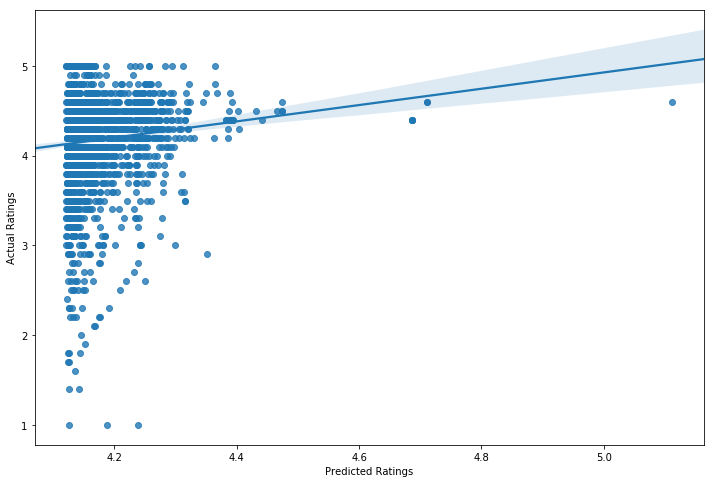

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
df=df.dropna( axis=0, how='any' ) 
X = df[['Reviews', 'Size','Installs','Price','TypeEncode']].values
Y = df.Rating
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
linreg=LinearRegression().fit(X_train,Y_train)
R_linreg=linreg.predict(X_test)
print('Test Accuracy:',linreg.score(X_test,Y_test))
MSE=mean_squared_error(Y_test,R_linreg)
print('mean square error:', MSE)
plt.figure().set_size_inches(12,8)
sns.regplot(R_linreg,Y_test)
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()




### Installs

Test Accuracy: 0.23025184780043007
mean square error: 1715218559356613.0


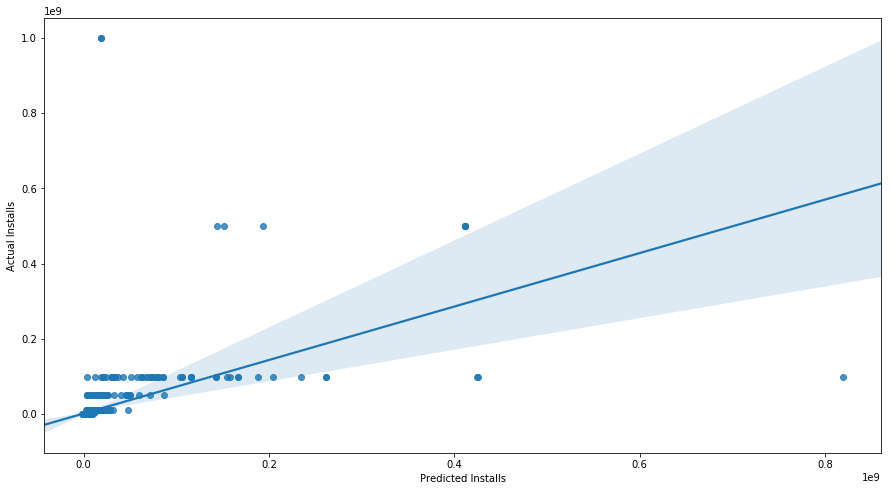

In [11]:
X = df[['Reviews', 'Size','Price','Rating','TypeEncode']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
linreg=LinearRegression().fit(X_train,Y_train)
R_linreg=linreg.predict(X_test)
print('Test Accuracy:',linreg.score(X_test,Y_test))
MSE=mean_squared_error(Y_test,R_linreg)
print('mean square error:', MSE)
plt.figure().set_size_inches(15,8)
sns.regplot(R_linreg,Y_test)
plt.xlabel('Predicted Installs')
plt.ylabel('Actual Installs')
plt.show()

### Reviews

Test Accuracy: 0.3039255969350174
mean square error: 2553550794450.558


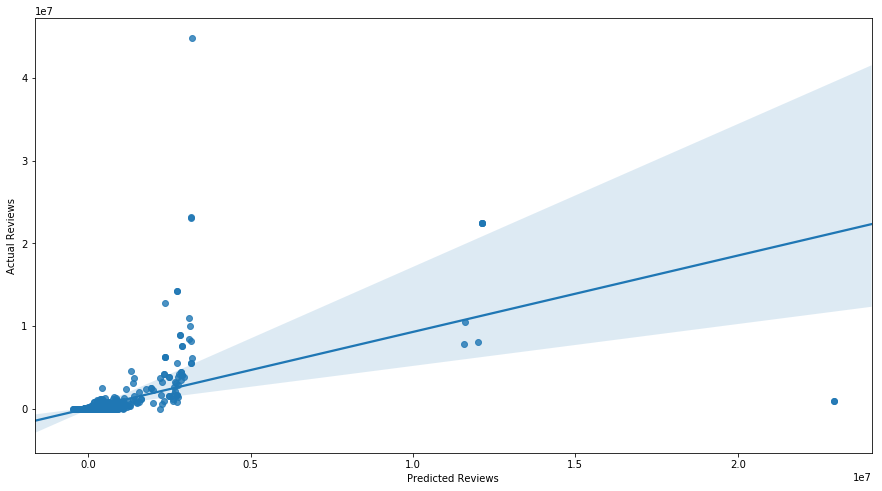

In [12]:
X = df[[ 'Size','Installs','Rating']].values
Y = df.Reviews
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
linreg=LinearRegression().fit(X_train,Y_train)
R_linreg=linreg.predict(X_test)
print('Test Accuracy:',linreg.score(X_test,Y_test))
MSE=mean_squared_error(Y_test,R_linreg)
print('mean square error:', MSE)
plt.figure().set_size_inches(15,8)
sns.regplot(R_linreg,Y_test)
plt.xlabel('Predicted Reviews')
plt.ylabel('Actual Reviews')
plt.show()

Linear regression performed badly, so we started to focus on classification models.

## Dummy Classifier
The dummy classifier is be our “baseline” measure of performance, because it represents the success rate one should expect to achieve even if simply guessing.
### stratified, most_frequent, uniform

### Rating

In [13]:
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier

X = df[['Reviews', 'Size','Installs']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

from sklearn.dummy import DummyClassifier
dummy_majority=OneVsRestClassifier(DummyClassifier(strategy='stratified')).fit(X_train,Y_train) #generates predictions by respecting the training set’s class distribution.
Accuracy=dummy_majority.score(X_test,Y_test)
y_pred=dummy_majority.predict(X_test)
print('Stratified')
print('Accuracy:',Accuracy)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-------------------------------------------------------------------------------------')

dummy_majority2=OneVsRestClassifier(DummyClassifier(strategy='most_frequent')).fit(X_train,Y_train) #always predicts the most frequent label in the training set.
Accuracy2=dummy_majority2.score(X_test,Y_test)
y_pred=dummy_majority2.predict(X_test)
print('most frequent')
print('Accuracy:',Accuracy2)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-------------------------------------------------------------------------------------')
dummy_majority3=OneVsRestClassifier(DummyClassifier(strategy='uniform')).fit(X_train,Y_train) #generates predictions uniformly at random.
Accuracy3=dummy_majority3.score(X_test,Y_test)
y_pred=dummy_majority3.predict(X_test)
print('uniform')
print('Accuracy:',Accuracy3)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-------------------------------------------------------------------------------------')

Stratified
Accuracy: 0.6511749347258485
recall score: 0.6610966057441253
precistion score: 0.5555875965775895
f1 score: 0.584341216872743
-------------------------------------------------------------------------------------
most frequent
Accuracy: 0.7028720626631854
recall score: 0.7028720626631854
precistion score: 0.4940291364724008
f1 score: 0.5802304792055489
-------------------------------------------------------------------------------------
uniform
Accuracy: 0.7028720626631854
recall score: 0.7028720626631854
precistion score: 0.4940291364724008
f1 score: 0.5802304792055489
-------------------------------------------------------------------------------------


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Installs

In [14]:
X = df[['Reviews', 'Size','Rating','Price']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

from sklearn.dummy import DummyClassifier
dummy_majority=OneVsOneClassifier(DummyClassifier(strategy='stratified')).fit(X_train,Y_train) #generates predictions by respecting the training set’s class distribution.
Accuracy=dummy_majority.score(X_test,Y_test)
y_pred=dummy_majority.predict(X_test)
print('Stratified')
print('Accuracy:',Accuracy)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('F1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-------------------------------------------------------------------------------------')
dummy_majority2=OneVsOneClassifier(DummyClassifier(strategy='most_frequent')).fit(X_train,Y_train) #always predicts the most frequent label in the training set.
Accuracy2=dummy_majority2.score(X_test,Y_test)
y_pred=dummy_majority2.predict(X_test)
print('most frequent')
print('Accuracy:',Accuracy2)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-------------------------------------------------------------------------------------')
dummy_majority3=OneVsOneClassifier(DummyClassifier(strategy='uniform')).fit(X_train,Y_train) #generates predictions uniformly at random.
Accuracy3=dummy_majority3.score(X_test,Y_test)
y_pred=dummy_majority3.predict(X_test)
print('uniform')
print('Accuracy:',Accuracy3)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-------------------------------------------------------------------------------------')

Stratified
Accuracy: 0.14203655352480418
recall score: 0.13107049608355092
precistion score: 0.1026269698512654
F1 score: 0.09946736891550065
-------------------------------------------------------------------------------------
most frequent
Accuracy: 0.1618798955613577
recall score: 0.1618798955613577
precistion score: 0.02620510058695608
f1 score: 0.04510810572945698
-------------------------------------------------------------------------------------


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


uniform
Accuracy: 0.05691906005221932
recall score: 0.0433420365535248
precistion score: 0.07833611422058927
f1 score: 0.052433906304128974
-------------------------------------------------------------------------------------


### Reviews

In [15]:
df=df.dropna( axis=0, how='any' ) 
X = df[['Installs', 'Size','Rating','Price']].values
Y = df.ReviewsEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

from sklearn.dummy import DummyClassifier
dummy_majority=OneVsOneClassifier(DummyClassifier(strategy='stratified')).fit(X_train,Y_train) #generates predictions by respecting the training set’s class distribution.
Accuracy=dummy_majority.score(X_test,Y_test)
y_pred=dummy_majority.predict(X_test)
print('Stratified')
print('Accuracy:',Accuracy)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-------------------------------------------------------------------------------------')
dummy_majority2=OneVsOneClassifier(DummyClassifier(strategy='most_frequent')).fit(X_train,Y_train) #always predicts the most frequent label in the training set.
y_pred=dummy_majority2.predict(X_test)
print('most frequent')
print('Accuracy:',dummy_majority2.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-------------------------------------------------------------------------------------')
dummy_majority3=OneVsOneClassifier(DummyClassifier(strategy='uniform')).fit(X_train,Y_train) #generates predictions uniformly at random.
Accuracy3=dummy_majority3.score(X_test,Y_test)
y_pred=dummy_majority3.predict(X_test)
print('uniform')
print('Accuracy:',Accuracy3)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-------------------------------------------------------------------------------------')

Stratified
Accuracy: 0.19530026109660575
recall score: 0.19634464751958225
precistion score: 0.18790731528328644
f1 score: 0.18992732218159467
-------------------------------------------------------------------------------------
most frequent
Accuracy: 0.24960835509138382
recall score: 0.24960835509138382
precistion score: 0.06230433093142635
f1 score: 0.09971817278201543
-------------------------------------------------------------------------------------
uniform
Accuracy: 0.1227154046997389
recall score: 0.11331592689295039
precistion score: 0.18965188646679296
f1 score: 0.13039059058909802
-------------------------------------------------------------------------------------


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Naive Bayes Classifier
#### Rating

In [16]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler 

X = df[['Reviews', 'Size','Installs','Price']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.MinMaxScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

NBModel= OneVsRestClassifier(GaussianNB( )).fit(X_train_transformed,Y_train)
Score=NBModel.score(X_test_transformed,Y_test)
y_pred=NBModel.predict(X_test)
print('GaussianNB Test Accuracy:',Score)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-----------------------------------------------------------------------------------------')

NBModel1= OneVsRestClassifier(BernoulliNB( )).fit(X_train_transformed,Y_train)
Score=NBModel1.score(X_test_transformed,Y_test)
y_pred1=NBModel1.predict(X_test)
print('BernoulliNB Test Accuracy:',Score)
print('recall score:',recall_score(Y_test,y_pred1,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred1,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred1,average='weighted'))

print('-----------------------------------------------------------------------------------------')

NBModel2= OneVsRestClassifier(MultinomialNB( )).fit(X_train_transformed,Y_train)
Score=NBModel2.score(X_test_transformed,Y_test)
y_pred2=NBModel2.predict(X_test)
print('MultinomialNB Test Accuracy:',Score)
print('recall score:',recall_score(Y_test,y_pred2,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred2,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred2,average='weighted'))





GaussianNB Test Accuracy: 0.17023498694516973
recall score: 0.7028720626631854
precistion score: 0.4940291364724008
f1 score: 0.5802304792055489
-----------------------------------------------------------------------------------------
BernoulliNB Test Accuracy: 0.7028720626631854
recall score: 0.7028720626631854
precistion score: 0.4940291364724008
f1 score: 0.5802304792055489
-----------------------------------------------------------------------------------------
MultinomialNB Test Accuracy: 0.7028720626631854
recall score: 0.4595300261096606
precistion score: 0.6351112244710174
f1 score: 0.46982917006447156


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py

#### Installs

In [17]:
X = df[['Reviews', 'Size','Rating','Price']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

scaler=preprocessing.MinMaxScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

NBModel= OneVsRestClassifier(GaussianNB()).fit(X_train,Y_train)
Score=NBModel.score(X_test,Y_test)
y_pred=NBModel.predict(X_test)
print('Test Accuracy:',Score)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))
print('-----------------------------------------------------------------------------------------')
NBModel1= OneVsRestClassifier(BernoulliNB()).fit(X_train,Y_train)
Score=NBModel1.score(X_test,Y_test)
y_pred1=NBModel1.predict(X_test)
print('Test Accuracy:',Score)
print('recall score:',recall_score(Y_test,y_pred1,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred1,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred1,average='weighted'))
print('-----------------------------------------------------------------------------------------')
NBModel2= OneVsRestClassifier(MultinomialNB() ).fit(X_train,Y_train)
Score=NBModel2.score(X_test,Y_test)
y_pred2=NBModel2.predict(X_test)
print('Test Accuracy:',Score)
print('recall score:',recall_score(Y_test,y_pred2,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred2,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred2,average='weighted'))

Test Accuracy: 0.3660574412532637
recall score: 0.3660574412532637
precistion score: 0.29682420030329953
f1 score: 0.29678325134051303
-----------------------------------------------------------------------------------------
Test Accuracy: 0.17545691906005223
recall score: 0.17545691906005223
precistion score: 0.047925377131026084
f1 score: 0.0654469480440436
-----------------------------------------------------------------------------------------


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test Accuracy: 0.07049608355091384
recall score: 0.07049608355091384
precistion score: 0.021930831221711324
f1 score: 0.025745056266217453


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Reviews

In [18]:
df=df.dropna( axis=0, how='any' ) 
X = df[['Installs', 'Size','Rating','Price']].values
Y = df.ReviewsEncode

scaler=preprocessing.MinMaxScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

NBModel= OneVsRestClassifier(GaussianNB( )).fit(X_train,Y_train)
Score=NBModel.score(X_test,Y_test)
y_pred=NBModel.predict(X_test)
print('Test Accuracy:',Score)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

print('-----------------------------------------------------------------------------------------')

NBModel1= OneVsRestClassifier(BernoulliNB()).fit(X_train,Y_train)
Score1=NBModel1.score(X_test,Y_test)
y_pred1=NBModel1.predict(X_test)
print('Test Accuracy:',Score1)
print('recall score:',recall_score(Y_test,y_pred1,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred1,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred1,average='weighted'))

print('-----------------------------------------------------------------------------------------')

NBModel2= OneVsRestClassifier(MultinomialNB() ).fit(X_train,Y_train)
Score2=NBModel2.score(X_test,Y_test)
y_pred2=NBModel2.predict(X_test)
print('Test Accuracy:',Score2)
print('recall score:',recall_score(Y_test,y_pred2,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred2,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred2,average='weighted'))


Test Accuracy: 0.3660574412532637
recall score: 0.3660574412532637
precistion score: 0.29682420030329953
f1 score: 0.29678325134051303
-----------------------------------------------------------------------------------------
Test Accuracy: 0.17545691906005223
recall score: 0.17545691906005223
precistion score: 0.047925377131026084
f1 score: 0.0654469480440436
-----------------------------------------------------------------------------------------
Test Accuracy: 0.07049608355091384


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


recall score: 0.07049608355091384
precistion score: 0.021930831221711324
f1 score: 0.025745056266217453


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Logistic regression
### Ridge regulation

#### Rating

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_multilabel_classification


X = df[['Reviews', 'Size','Installs','Price']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

LogRegModel= OneVsRestClassifier(LogisticRegression(C=1 )).fit(X_train_transformed,Y_train)
Score=LogRegModel.score(X_test_transformed,Y_test)
y_pred=LogRegModel.predict(X_test)
print('Test Accuracy:',Score)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))



Test Accuracy: 0.7039164490861619
recall score: 0.6443864229765013
precistion score: 0.5390100634717683
f1 score: 0.5762918552940259


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Rating with Regularization

In [20]:
from sklearn.model_selection import cross_val_score

X = df[['Reviews', 'Size','Installs','Price']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)



best_score=0
kfolds=5
for c in [ 0.01,0.1,1,10,100]:
    RM=LogisticRegression(C=c)
    
    scores=cross_val_score(RM, X_train_transformed,Y_train, cv=kfolds)
    score=np.mean(scores)
    #print(scores)
    if score> best_score:
        best_score=score
        best_parameters=c
SelectedRM=OneVsRestClassifier(LogisticRegression(C=best_parameters)).fit(X_train_transformed,Y_train)
test_score=SelectedRM.score(X_test_transformed,Y_test)
y_pred=SelectedRM.predict(X_test)
print('Test Accuracy:',test_score)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

Test Accuracy: 0.7039164490861619
recall score: 0.6443864229765013
precistion score: 0.5390100634717683
f1 score: 0.5762918552940259


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Installs

In [21]:
X = df[['Reviews', 'Size','Rating','Price']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)



best_score=0
kfolds=5
for c in [ 0.01,0.1,1,10,100]:
    RM=LogisticRegression(C=c)
    
    scores=cross_val_score(RM, X_train_transformed,Y_train, cv=kfolds)
    score=np.mean(scores)
    #print(scores)
    if score> best_score:
        best_score=score
        best_parameters=c
SelectedRM=OneVsRestClassifier(LogisticRegression(C=best_parameters)).fit(X_train_transformed,Y_train)
test_score=SelectedRM.score(X_test_transformed,Y_test)
y_pred=SelectedRM.predict(X_test)
print('Test Accuracy:',test_score)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))


Test Accuracy: 0.3023498694516971
recall score: 0.028198433420365536
precistion score: 0.000795151647362788
f1 score: 0.0015466890855253823


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

df=df.dropna( axis=0, how='any' ) 
X = df[['Installs', 'Size','Rating','Price']].values
Y = df.ReviewsEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)



best_score=0
kfolds=5
for c in [ 0.01,0.1,1,10,100]:
    RM=LogisticRegression(C=c)
    scores=cross_val_score(RM, X_train_transformed,Y_train, cv=kfolds)
    score=np.mean(scores)
    #print(scores)
    if score> best_score:
        best_score=score
        best_parameters=c
SelectedRM=OneVsRestClassifier(LogisticRegression(C=best_parameters)).fit(X_train_transformed,Y_train)
test_score=SelectedRM.score(X_test_transformed,Y_test)
y_pred=SelectedRM.predict(X_test)


print('Test Accuracy:',test_score)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

Test Accuracy: 0.4715404699738903
recall score: 0.006788511749347258
precistion score: 4.608389177102578e-05
f1 score: 9.154632027128045e-05


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

X = df[['Reviews', 'Size','Installs','Price']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)


treeModel=OneVsRestClassifier(DecisionTreeClassifier(max_depth=3)).fit(X_train_transformed,Y_train)
Accuracy = treeModel.score(X_test_transformed,Y_test)
y_pred=treeModel.predict(X_test)

print('Accuracy',Accuracy)

print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

Accuracy 0.7023498694516971
recall score: 0.7028720626631854
precistion score: 0.4940291364724008
f1 score: 0.5802304792055489


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
X = df[['Reviews', 'Size','Price','Rating']].values
Y = df.Installs

X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)


treeModel=OneVsRestClassifier(DecisionTreeClassifier(max_depth=5)).fit(X_train_transformed,Y_train)
Accuracy = treeModel.score(X_test_transformed,Y_test)
y_pred=treeModel.predict(X_test)
print('Accuracy',Accuracy)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

Accuracy 0.5409921671018276
recall score: 0.03342036553524804
precistion score: 0.0016865569764869504
f1 score: 0.003096036088580679


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
df=df.dropna( axis=0, how='any' ) 
X = df[['Installs', 'Size','Rating','Price']].values
Y = df.ReviewsEncode

X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)


treeModel=OneVsRestClassifier(DecisionTreeClassifier(max_depth=5)).fit(X_train_transformed,Y_train)
Accuracy = treeModel.score(X_test_transformed,Y_test)
y_pred=treeModel.predict(X_test)
print('Accuracy',Accuracy)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

Accuracy 0.7331592689295039
recall score: 0.006788511749347258
precistion score: 4.613207148014342e-05
f1 score: 9.16413839475746e-05


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest

#### Rating

In [26]:
from sklearn.ensemble import RandomForestClassifier
X = df[['Reviews', 'Size','Installs','Price']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
forestModel= OneVsRestClassifier(RandomForestClassifier (n_estimators=2, max_features=4,max_depth=1, random_state=0)) 
forestModel.fit(X_train, Y_train)
y_pred=forestModel.predict(X_test)
print('RandomForest Accuracy:',forestModel.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

RandomForest Accuracy: 0.7028720626631854
recall score: 0.7028720626631854
precistion score: 0.4940291364724008
f1 score: 0.5802304792055489


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Installs

In [27]:
X = df[['Reviews', 'Size','Price','Rating']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
forestModel= OneVsRestClassifier(RandomForestClassifier (n_estimators=4, max_features=2,max_depth=9, random_state=0) )
forestModel.fit(X_train, Y_train)
y_pred=forestModel.predict(X_test)
print('RandomForest Accuracy:',forestModel.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

RandomForest Accuracy: 0.5524804177545692
recall score: 0.5524804177545692
precistion score: 0.5179720868532989
f1 score: 0.5109271931673457


#### Reviews

In [28]:
df=df.dropna( axis=0, how='any' ) 
X = df[['Installs', 'Size','Rating','Price']].values
Y = df.ReviewsEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
forestModel= OneVsRestClassifier(RandomForestClassifier (n_estimators=4, max_features=2,max_depth=9, random_state=0) )
forestModel.fit(X_train, Y_train)
y_pred=forestModel.predict(X_test)
print('RandomForest Accuracy:',forestModel.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

RandomForest Accuracy: 0.7321148825065275
recall score: 0.7321148825065275
precistion score: 0.7365278332765595
f1 score: 0.7332800199447433


## Adaboost

### Rating

In [29]:
from sklearn.ensemble import AdaBoostClassifier
X = df[['Reviews', 'Size','Installs','Price']].values
Y = df.RatingEncode
BoostModel= OneVsRestClassifier(AdaBoostClassifier(n_estimators=5))
BoostModel.fit(X_train, Y_train)
y_pred=BoostModel.predict(X_test)
print('AdaBoost Accuracy:',BoostModel.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

AdaBoost Accuracy: 0.7117493472584856
recall score: 0.7117493472584856
precistion score: 0.7173804308673228
f1 score: 0.7114650768340616


### Installs

In [30]:
X = df[['Reviews', 'Size','Price','Rating']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
BoostModel= OneVsRestClassifier(AdaBoostClassifier(n_estimators=5))
BoostModel.fit(X_train, Y_train)
y_pred=BoostModel.predict(X_test)
print('AdaBoost Accuracy:',BoostModel.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

AdaBoost Accuracy: 0.49973890339425586
recall score: 0.49973890339425586
precistion score: 0.36870851712152414
f1 score: 0.41593074629491206


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Reviews

In [31]:
df=df.dropna( axis=0, how='any' ) 
X = df[['Installs', 'Size','Rating','Price']].values
Y = df.ReviewsEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
BoostModel=  OneVsRestClassifier(AdaBoostClassifier(n_estimators=5))
BoostModel.fit(X_train, Y_train)
y_pred=BoostModel.predict(X_test)
print('AdaBoost Accuracy:',BoostModel.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

AdaBoost Accuracy: 0.7117493472584856
recall score: 0.7117493472584856
precistion score: 0.7173804308673228
f1 score: 0.7114650768340616


## Nearest Neighbors Classification

#### Rating

In [32]:
np.random.seed(0)
df=df.dropna( axis=0, how='any' ) 
X = df[[ 'Size','Reviews','Installs']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

# Create and fit a nearest-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier
knn =  OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train_transformed, Y_train) 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

y_pred=knn.predict(X_test_transformed)
accuracy = knn.score(X_test_transformed,Y_test)
print('Accuracy', accuracy)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

Accuracy 0.6657963446475196
recall score: 0.6657963446475196
precistion score: 0.6001101240978716
f1 score: 0.6243587232140271


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Installs

In [33]:
np.random.seed(0)
df=df.dropna( axis=0, how='any' ) 
X = df[[ 'Size','Reviews','Rating','Price']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

# Create and fit a nearest-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier
knn =  OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train_transformed, Y_train) 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

y_pred=knn.predict(X_test_transformed)
accuracy = knn.score(X_test_transformed,Y_test)
print('Accuracy', accuracy)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

Accuracy 0.3007832898172324
recall score: 0.3007832898172324
precistion score: 0.2792944811728619
f1 score: 0.2845653136955985


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Reviews

In [34]:
df=df.dropna( axis=0, how='any' ) 
X = df[['Installs', 'Size','Rating','Price']].values
Y = df.ReviewsEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

# Create and fit a nearest-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier
knn = OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train_transformed, Y_train) 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

y_pred=knn.predict(X_test_transformed)
accuracy = knn.score(X_test_transformed,Y_test)
print('Accuracy', accuracy)
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

Accuracy 0.48511749347258487
recall score: 0.48511749347258487
precistion score: 0.49602687912143567
f1 score: 0.48918321891800676


# SVM

#### Rating:

In [35]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

df=df.dropna( axis=0, how='any' ) 
X = df[[ 'Reviews','Size']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=MinMaxScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

best_score=0
kfolds=5

for C in [0.1,1,5,10,100]:
    for gamma in [0.1,1,5,10,100]:
        svm_Model= OneVsRestClassifier(SVC(kernel='rbf', gamma=gamma, C=C)).fit(X_train_transformed, Y_train)
        scores=cross_val_score(svm_Model, X_train_transformed,Y_train, cv=kfolds)
        score=np.mean(scores)
       #print(scores)
        if score> best_score:
            best_score=score
            best_C=C
            best_gamma=gamma
SelectedM=LogisticRegression=SVC(kernel='rbf', gamma=best_gamma,C=best_C).fit(X_train_transformed,Y_train)
test_score=SelectedM.score(X_test_transformed,Y_test)
print(best_gamma)
print(best_C)
print('SVM accuracy:',test_score)

0.1
0.1
SVM accuracy: 0.7028720626631854


accuracy of best gamma,c

In [36]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import SVC
df=df.dropna( axis=0, how='any' ) 
X = df[[ 'Reviews','Size']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=MinMaxScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)
SelectedM= OneVsRestClassifier(SVC(kernel='rbf', gamma=0.1,C=0.1)).fit(X_train_transformed,Y_train)
y_pred=SelectedM.predict(X_test_transformed)
print('SVM accuracy:',SelectedM.score(X_test_transformed,Y_test))

print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))

SVM accuracy: 0.7028720626631854
recall score: 0.7028720626631854
f1 score: 0.5802304792055489
precistion score: 0.4940291364724008


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
#from sklearn.metrics import roc_curve
#FalsePositive, TruePositive, thresholds = roc_curve(Y_test, LogRegModel.predict_proba(X_test)[:,1])
#plt.plot(FalsePositive, TruePositive, label="ROC Curve")
#plt.xlabel("FalsePositive")
#plt.ylabel("TruePositive (recall)")

#### Installs:

In [38]:
df=df.dropna( axis=0, how='any' ) 
X = df[[ 'Reviews','Size','Rating','Price']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=MinMaxScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

best_score=0
kfolds=5

for C in [0.1,1,5,10,100]:
    for gamma in [0.1,1,5,10,100]:
        svm_Model= OneVsRestClassifier(SVC(kernel='rbf', gamma=gamma, C=C)).fit(X_train_transformed, Y_train)
        scores=cross_val_score(svm_Model, X_train_transformed,Y_train, cv=kfolds)
        score=np.mean(scores)
       #print(scores)
        if score> best_score:
            best_score=score
            best_C=C
            best_gamma=gamma
SelectedM=SVC(kernel='rbf', gamma=best_gamma,C=best_C).fit(X_train_transformed,Y_train)
test_score=SelectedM.score(X_test_transformed,Y_test)

print(best_gamma)
print(best_C)
print('SVM accuracy:',test_score)

100
100
SVM accuracy: 0.34360313315926894


In [39]:
df=df.dropna( axis=0, how='any' ) 
X = df[[ 'Reviews','Size','Rating','Price']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=MinMaxScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)
SelectedM= OneVsRestClassifier(SVC(kernel='rbf', gamma=100,C=100)).fit(X_train_transformed,Y_train)
y_pred=SelectedM.predict(X_test_transformed)
print('SVM accuracy:',SelectedM.score(X_test_transformed,Y_test))

print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))

SVM accuracy: 0.3258485639686684
recall score: 0.3258485639686684
f1 score: 0.3006922573133625
precistion score: 0.3043629656419738


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Reviews

In [40]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
df=df.dropna( axis=0, how='any' ) 
X = df[['Installs', 'Size','Rating','Price']].values
Y = df.ReviewsEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=MinMaxScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)
SelectedM= OneVsRestClassifier(SVC(kernel='rbf', gamma=100,C=100)).fit(X_train_transformed,Y_train)
y_pred=SelectedM.predict(X_test_transformed)
print('SVM accuracy:',SelectedM.score(X_test_transformed,Y_test))
print('recall score:',recall_score(Y_test,y_pred,average='weighted'))
print('precistion score:',precision_score(Y_test,y_pred,average='weighted'))
print('f1 score:',f1_score(Y_test,y_pred,average='weighted'))

SVM accuracy: 0.5352480417754569
recall score: 0.5352480417754569
precistion score: 0.5002973275242643
f1 score: 0.4977149553132832


## LDA

#### Rating

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score

df=df.dropna( axis=0, how='any' ) 
X = df[[ 'Reviews','Size']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

LDAmodelFitted =  OneVsRestClassifier(LinearDiscriminantAnalysis()).fit(X_train, Y_train)
predict_LDA=LDAmodelFitted.predict(X_test)
print('LDA score',LDAmodelFitted.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,predict_LDA,average='weighted'))
print('precistion score:',precision_score(Y_test,predict_LDA,average='weighted'))
print('f1 score:',f1_score(Y_test,predict_LDA,average='weighted'))
#con_LDA = confusion_matrix(Y_test, predict_LDA)
#print('LDA confusion matrix:')
#print(con_LDA)
#print('LDA precision:',precision_score(Y_test,predict_LDA))
#print('LDA recall:',recall_score(Y_test,predict_LDA))

LDA score 0.7028720626631854
recall score: 0.7028720626631854
precistion score: 0.4940291364724008
f1 score: 0.5802304792055489


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Installs

In [42]:
X = df[[ 'Reviews','Size','Rating','Price']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

LDAmodelFitted =  OneVsRestClassifier(LinearDiscriminantAnalysis()).fit(X_train, Y_train)
predict_LDA=LDAmodelFitted.predict(X_test)
print('LDA score',LDAmodelFitted.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,predict_LDA,average='weighted'))
print('precistion score:',precision_score(Y_test,predict_LDA,average='weighted'))
print('f1 score:',f1_score(Y_test,predict_LDA,average='weighted'))
#con_LDA = confusion_matrix(Y_test, predict_LDA)
#print('LDA confusion matrix:')
#print(con_LDA)


LDA score 0.20522193211488252
recall score: 0.20522193211488252
precistion score: 0.1329625519673581
f1 score: 0.12501773902791813


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Reviews

In [43]:
df=df.dropna( axis=0, how='any' ) 
X = df[['Installs', 'Size','Rating','Price']].values
Y = df.ReviewsEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
LDAmodelFitted =  OneVsRestClassifier(LinearDiscriminantAnalysis()).fit(X_train, Y_train)
predict_LDA=LDAmodelFitted.predict(X_test)
print('LDA score',LDAmodelFitted.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,predict_LDA,average='weighted'))
print('precistion score:',precision_score(Y_test,predict_LDA,average='weighted'))
print('f1 score:',f1_score(Y_test,predict_LDA,average='weighted'))

LDA score 0.3013054830287206
recall score: 0.3013054830287206
precistion score: 0.26109434755138017
f1 score: 0.2239350694610523


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## QDA

#### Rating

In [16]:
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler

df=df.dropna( axis=0, how='any' ) 
X = df[[ 'Reviews','Size']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)
scaler=MinMaxScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)


QDAmodelFitted =  OneVsRestClassifier(QuadraticDiscriminantAnalysis(reg_param=0.8)).fit(X_train_transformed, Y_train)
predict_QDA=QDAmodelFitted.predict(X_test_transformed)
print('QDA score',QDAmodelFitted.score(X_test_transformed,Y_test))
print('recall score:',recall_score(Y_test,predict_QDA,average='weighted'))
print('precistion score:',precision_score(Y_test,predict_QDA,average='weighted'))
print('f1 score:',f1_score(Y_test,predict_QDA,average='weighted'))
#con_QDA = confusion_matrix(Y_test, predict_QDA)
#print('QDA confusion matrix:')
#print(con_QDA)
#print('QDA precision:',precision_score(Y_test,predict_QDA))
#print('QDA recall:',recall_score(Y_test,predict_QDA))

QDA score 0.7028720626631854
recall score: 0.7028720626631854
precistion score: 0.4940291364724008
f1 score: 0.5802304792055489


C:\Users\Carol\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Carol\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Carol\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Installs

In [17]:
X = df[[ 'Reviews','Size','Rating']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

QDAmodelFitted =  OneVsRestClassifier(QuadraticDiscriminantAnalysis()).fit(X_train, Y_train)
predict_QDA=QDAmodelFitted.predict(X_test)
print('QDA score',QDAmodelFitted.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,predict_QDA,average='weighted'))
print('precistion score:',precision_score(Y_test,predict_QDA,average='weighted'))
print('f1 score:',f1_score(Y_test,predict_QDA,average='weighted'))

QDA score 0.3906005221932115
recall score: 0.3906005221932115
precistion score: 0.38503717146646577
f1 score: 0.3659392710020894


C:\Users\Carol\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Carol\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Carol\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Reviews

In [46]:
df=df.dropna( axis=0, how='any' ) 
X = df[['Installs', 'Size','Rating']].values
Y = df.ReviewsEncode

QDAmodelFitted =  OneVsRestClassifier(QuadraticDiscriminantAnalysis()).fit(X_train, Y_train)
predict_QDA=QDAmodelFitted.predict(X_test)
print('QDA score',QDAmodelFitted.score(X_test,Y_test))
print('recall score:',recall_score(Y_test,predict_QDA,average='weighted'))
print('precistion score:',precision_score(Y_test,predict_QDA,average='weighted'))
print('f1 score:',f1_score(Y_test,predict_QDA,average='weighted'))

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA score 0.3906005221932115
recall score: 0.3906005221932115
precistion score: 0.38503717146646577
f1 score: 0.3659392710020894


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Neural Network

#### Rating

In [47]:
from sklearn.neural_network import MLPClassifier

X = df[['Installs', 'Size','Reviews','Price']].values
Y = df.RatingEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

MLPmodel= OneVsRestClassifier(MLPClassifier(solver='lbfgs', activation='relu', random_state=0, hidden_layer_sizes=[100,10], alpha=0.5)).fit(X_train_transformed,Y_train)
Accuracy=MLPmodel.score(X_test_transformed,Y_test)
print(Accuracy)

y_pred=MLPmodel.predict(X_test_transformed)

print('Precision:',metrics.precision_score(Y_test, y_pred, average='weighted'))
print('Recall:',metrics.recall_score(Y_test, y_pred, average='weighted'))
print('F1:',metrics.f1_score(Y_test, y_pred, average='weighted'))




0.7023498694516971
Precision: 0.6100255910576906
Recall: 0.7023498694516971
F1: 0.5847054724409926


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Installs

In [48]:
from sklearn import metrics

X = df[['Rating', 'Size','Reviews','Price']].values
Y = df.Installs
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

MLPmodel= OneVsRestClassifier(MLPClassifier(solver='lbfgs', activation='relu', random_state=0, hidden_layer_sizes=[100,10], alpha=0.5)).fit(X_train_transformed,Y_train)
Accuracy=MLPmodel.score(X_test_transformed,Y_test)
print(Accuracy)

y_pred=MLPmodel.predict(X_test_transformed)

print('Precision:',metrics.precision_score(Y_test, y_pred, average='weighted'))
print('Recall:',metrics.recall_score(Y_test, y_pred, average='weighted'))
print('F1:',metrics.f1_score(Y_test, y_pred, average='weighted'))




0.41879895561357705
Precision: 0.38693757834138537
Recall: 0.41879895561357705
F1: 0.3660001941507495


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Reviews

In [49]:
from sklearn import metrics

X = df[['Installs', 'Size','Rating','Price']].values
Y = df.ReviewsEncode
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,random_state= 0)

scaler=preprocessing.StandardScaler().fit(X_train)
X_train_transformed=scaler.transform(X_train)
X_test_transformed=scaler.transform(X_test)

MLPmodel= OneVsRestClassifier(MLPClassifier(solver='lbfgs', activation='relu', random_state=0, hidden_layer_sizes=[100,10], alpha=0.5)).fit(X_train_transformed,Y_train)
Accuracy=MLPmodel.score(X_test_transformed,Y_test)
print('Accuracy:', Accuracy)

y_pred=MLPmodel.predict(X_test_transformed)

print('Precision:',metrics.precision_score(Y_test, y_pred, average='macro'))
print('Recall:',metrics.recall_score(Y_test, y_pred, average='micro'))
print('F1:',metrics.f1_score(Y_test, y_pred, average='weighted'))



Accuracy: 0.618798955613577
Precision: 0.5360305639200155
Recall: 0.618798955613577
F1: 0.6015693747609606


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Conclusion

## Comparison of accuracy

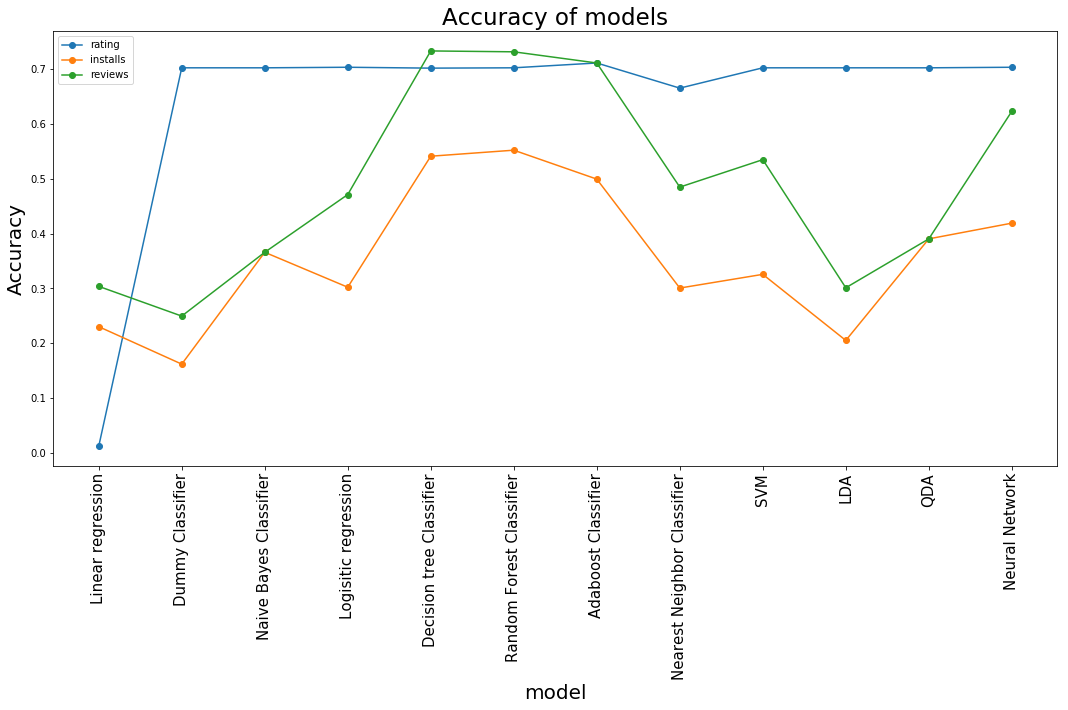

In [19]:
import matplotlib.pyplot as plt
def plotData(plt, data,a):
  x = [p[0] for p in data]
  y = [p[1] for p in data]
  plt.plot(x, y, '-o',label=a)
#0linear regression
#1dummy classifier
#2Naive Bayes Classifier
#3logisitic regression
#4decision tree
#5random forest
#6adaboost
#7nearest neighbor classifier
#8svm
#9lda
#10qda
#11NN
data_r=[(0,0.0119), (1,0.7029),(2,0.7029),
        (3,0.7039),(4,0.7023),(5, 0.7029),
        (6,0.7117),(7,0.6658),(8,0.7029),
        (9, 0.7029),(10,0.7029),(11,0.7039)]

data_i=[(0,0.2303),(1,0.1619),(2,0.3661),
        (3,0.3023),(4,0.5415),(5,0.5525),
        (6,0.4997),(7,0.3008),(8,0.3258),
        (9,0.2052),(10,0.3906),(11,0.4193)]

data_rv=[(0,0.3039),(1,0.2496),(2,0.3661),
         (3,0.4715),(4,0.7337),(5,0.7321),
         (6, 0.7117),(7,0.4851),(8, 0.5352),
         (9, 0.3013),(10,0.3906),(11,0.6235)]

plt.figure(figsize=(18,8))
plotData(plt, data_r,'rating')
plotData(plt, data_i,'installs')
plotData(plt, data_rv,'reviews')

plt.title("Accuracy of models",size=23)
plt.xlabel("model",size=20)
plt.xticks(np.arange(12), ('Linear regression','Dummy Classifier', 'Naive Bayes Classifier','Logisitic regression', 'Decision tree Classifier','Random Forest Classifier',
                           'Adaboost Classifier', 'Nearest Neighbor Classifier','SVM','LDA','QDA','Neural Network'), rotation=90,size=15)
plt.ylabel("Accuracy",size=20)
plt.legend()
plt.show()






Installs and reviews have similar result in both accuracy and F-measure. Their similar tendency might be due to their high correlation.  
  
Rating shows a high accuracy in most models, especially in classification models. However, we assume this result might be due to the unbalanced data.

### Comparison of F1 score

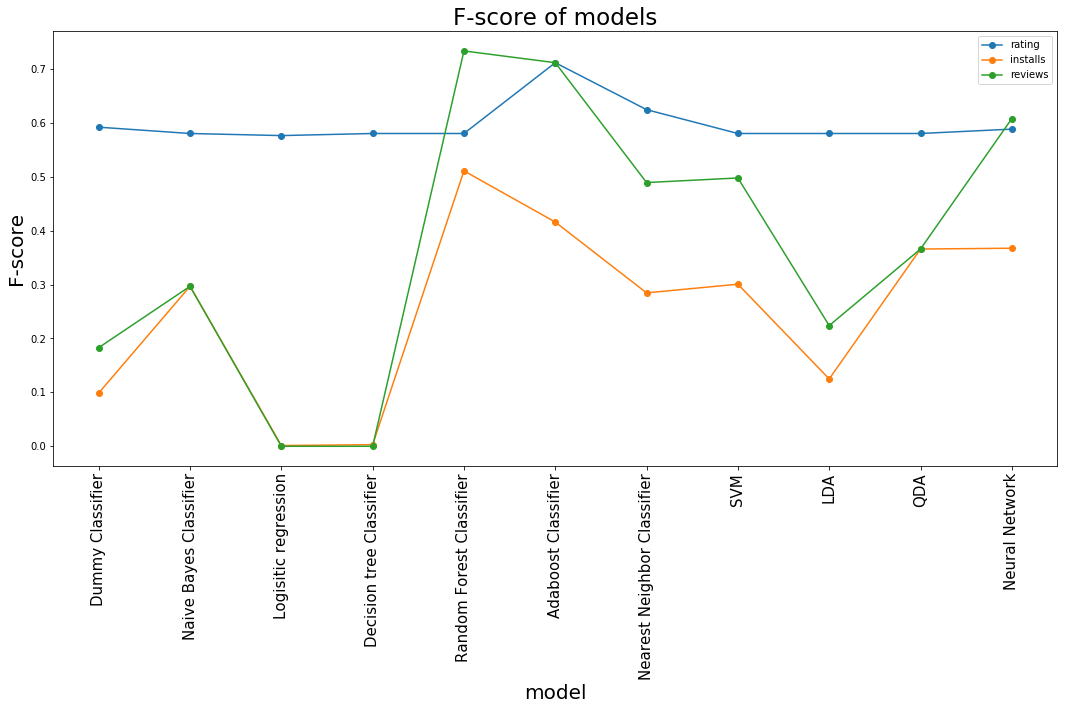

In [20]:
#0dummy classifier
#1Naive Bayes Classifier
#2logisitic regression
#3decision tree
#4random forest
#5adaboost
#6nearest neighbor classifier
#7svm
#8lda
#9qda
#10NN

data_r=[(0,0.5919),(1,0.5802),(2,0.5763),
        (3,0.5802),(4,0.5802),(5,0.7115),
        (6,0.6244),(7,0.5802),(8,0.5802),
        (9,0.5802),(10,0.5883)]


data_i=[(0,0.0989),(1,0.2968),(2,0.0015),
       (3,0.0031),(4,0.5109),(5,0.4159),
       (6,0.2846),(7,0.3007),(8,0.125),
       (9,0.3659),(10,0.3674)]


data_rv=[(0,0.183),(1,0.2968),(2,9.155e-05),
         (3,9.164e-05),(4,0.7333),(5,0.7115),
         (6,0.4892),(7,0.4977),(8,0.2239),
         (9,0.3659),(10,0.6078)]

plt.figure(figsize=(18,8))
plotData(plt, data_r,'rating')
plotData(plt, data_i,'installs')
plotData(plt, data_rv,'reviews')

plt.title("F-score of models",size=23)
plt.xlabel("model",size=20)
plt.xticks(np.arange(11), ('Dummy Classifier', 'Naive Bayes Classifier','Logisitic regression', 'Decision tree Classifier','Random Forest Classifier',
                           'Adaboost Classifier', 'Nearest Neighbor Classifier','SVM','LDA','QDA','Neural Network'), rotation=90,size=15)
plt.ylabel("F-score",size=20)
plt.legend()
plt.show()


This figure show some difference from the accuracy graph. All of them performs relatively better on random forest classifier and AdaBoost classifier. We could see that installs and reviews have bad results at logistic regression and decision tree classifier, so that even if the accuracy is high, we would not choose them as our best fit model.

## Comparison of Precision, Recall, and F-score

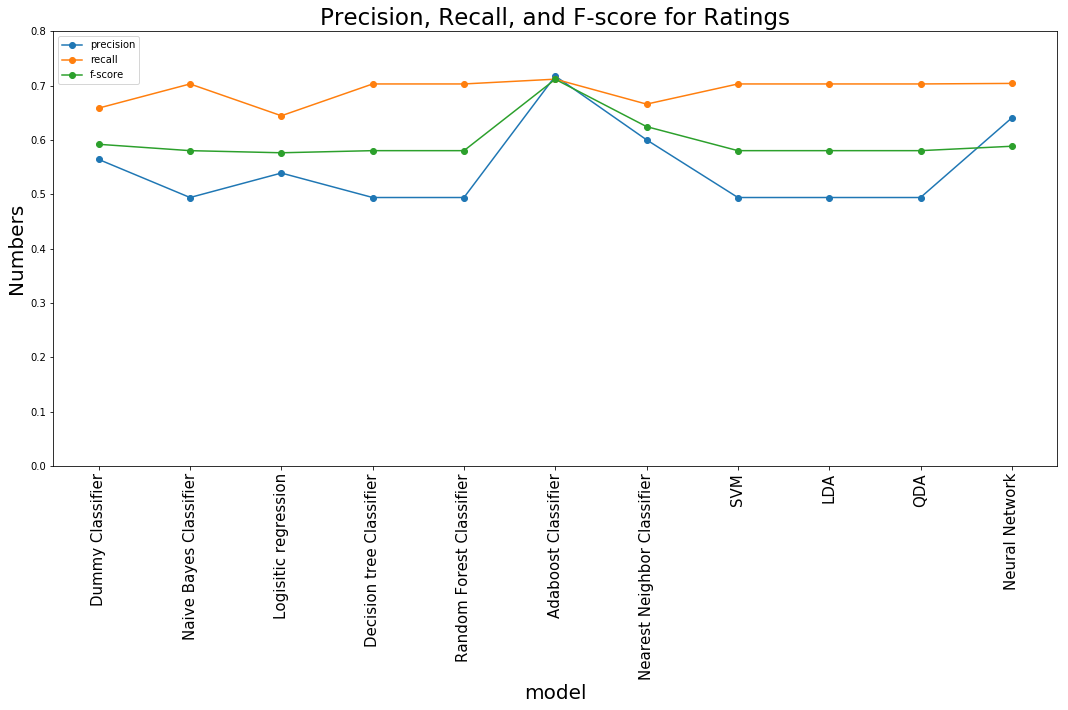

In [22]:
#0Dummy classifier
#1Naive Bayes Classifier
#2logisitic regression
#3decision tree
#4random forest
#5adaboost
#6nearest neighbor classifier
#7svm
#8lda
#9qda
#10NN
data_r=[(0,0.6585),(1 ,0.7029),(2, 0.6444),
        (3, 0.7029),(4, 0.7029),(5, 0.7117),
        (6, 0.6658),(7,0.7029),(8, 0.7029),
        (9, 0.7029),(10, 0.7039)]

data_p=[(0, 0.564),(1, 0.494),(2, 0.539),
       (3, 0.494),(4, 0.494),(5, 0.7174),
        (6, 0.6001),(7, 0.494),(8, 0.494),
        (9, 0.494),(10, 0.6405)]

data_f=[(0,0.5919),(1,0.5802),(2,0.5763),
        (3,0.5802),(4,0.5802),(5,0.7115),
        (6,0.6244),(7,0.5802),(8,0.5802),
        (9,0.5802),(10,0.5883)]

plt.figure(figsize=(18,8))
plt.ylim((0,0.8))
plotData(plt, data_p,'precision')
plotData(plt, data_r,'recall')
plotData(plt, data_f,'f-score')

plt.title("Precision, Recall, and F-score for Ratings",size=23)
plt.xlabel("model",size=20)
plt.xticks(np.arange(11), ('Dummy Classifier', 'Naive Bayes Classifier','Logisitic regression', 'Decision tree Classifier','Random Forest Classifier',
                           'Adaboost Classifier', 'Nearest Neighbor Classifier','SVM','LDA','QDA','Neural Network'), rotation=90,size=15)
plt.ylabel("Numbers",size=20)
plt.legend()
plt.show()

This figure is the overlook of the precision, recall, and F-measure of rating. They worked really well when using the AdaBoost classifier.

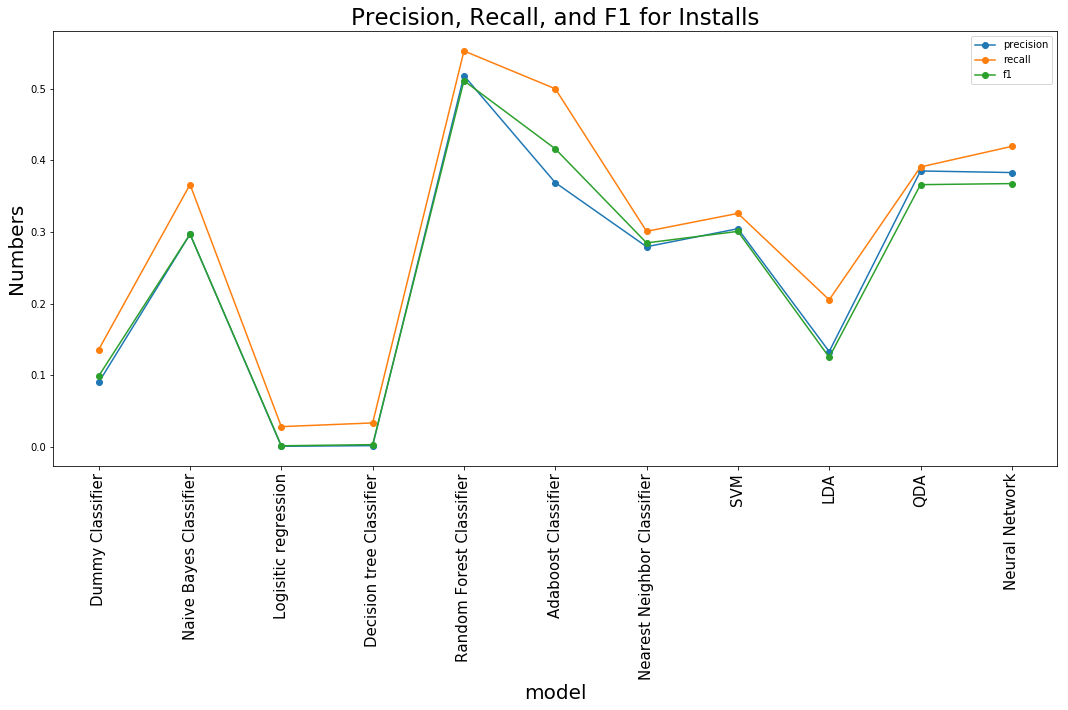

In [53]:
data_r=[(0,0.1358),(1,0.3661),(2,0.0282),
        (3,0.0334),(4, 0.5525),(5,0.4997),
        (6, 0.3008),(7,0.3258),(8,  0.2052),
        (9,  0.3906),(10, 0.4193)]

data_p=[(0,0.09),(1,0.2968),(2, 0.0008),
       (3, 0.0017),(4,0.518),(5,0.3687),
        (6,0.2793),(7,  0.3044),(8,0.133),
        (9,0.385),(10,0.3828)]

data_f=[(0,0.0989),(1,0.2968),(2,0.0015),
       (3,0.0031),(4,0.5109),(5,0.4159),
       (6,0.2846),(7,0.3007),(8,0.125),
       (9,0.3659),(10,0.3674)]

plt.figure(figsize=(18,8))
plotData(plt, data_p,'precision')
plotData(plt, data_r,'recall')
plotData(plt, data_f,'f1')

plt.title("Precision, Recall, and F1 for Installs",size=23)
plt.xlabel("model",size=20)
plt.xticks(np.arange(11), ('Dummy Classifier', 'Naive Bayes Classifier','Logisitic regression', 'Decision tree Classifier','Random Forest Classifier',
                           'Adaboost Classifier', 'Nearest Neighbor Classifier','SVM','LDA','QDA','Neural Network'), rotation=90,size=15)
plt.ylabel("Numbers",size=20)
plt.legend()
plt.show()

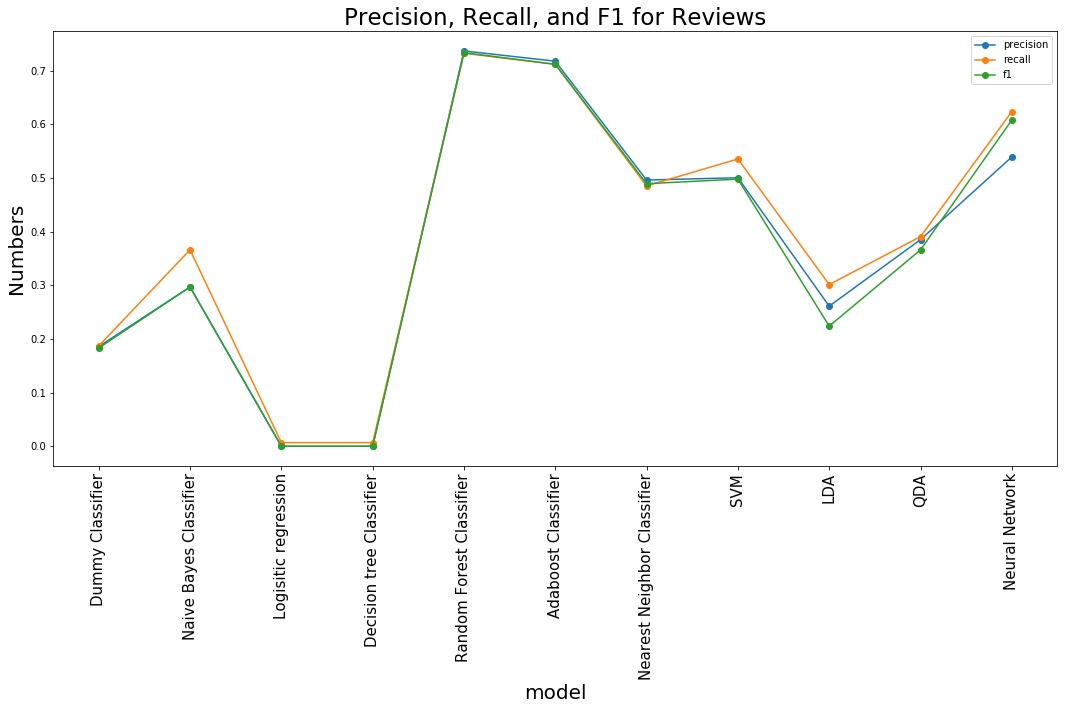

In [54]:
#0Dummy classifier
#1Naive Bayes Classifier
#2logisitic regression
#3decision tree
#4random forest
#5adaboost
#6nearest neighbor classifier
#7svm
#8lda
#9qda
#10NN
data_r=[(0,0.1869),(1,0.3661),(2,0.0068),
        (3,0.0068),(4, 0.7321),(5,0.7117),
        (6,0.4851),(7,0.5352),(8, 0.3013),
        (9,  0.3906),(10, 0.6235)]

data_p=[(0,0.1858),(1,0.2968),(2, 4.608e-05),
       (3, 4.613e-05),(4,0.7365),(5,0.7174),
        (6,0.496),(7, 0.5003),(8,0.2611),
        (9,0.385),(10,0.539)]

data_f=[(0,0.183),(1,0.2968),(2,9.155e-05),
         (3,9.164e-05),(4,0.7333),(5,0.7115),
         (6,0.4892),(7,0.4977),(8,0.2239),
         (9,0.3659),(10,0.6078)]

plt.figure(figsize=(18,8))
plotData(plt, data_p,'precision')
plotData(plt, data_r,'recall')
plotData(plt, data_f,'f1')

plt.title("Precision, Recall, and F1 for Reviews",size=23)
plt.xlabel("model",size=20)
plt.xticks(np.arange(11), ('Dummy Classifier', 'Naive Bayes Classifier','Logisitic regression', 'Decision tree Classifier','Random Forest Classifier',
                           'Adaboost Classifier', 'Nearest Neighbor Classifier','SVM','LDA','QDA','Neural Network'), rotation=90,size=15)
plt.ylabel("Numbers",size=20)
plt.legend()
plt.show()



The two figure shows the precision, recall, and F-measure of installs and reviews. As you can easily see, they have similar results on all three evaluating methods. Installs and reviews have highest performance when using random forest classifier. They have bad outcome at logistic regression and decision tree classifier, but the other models are having better results than our baseline.

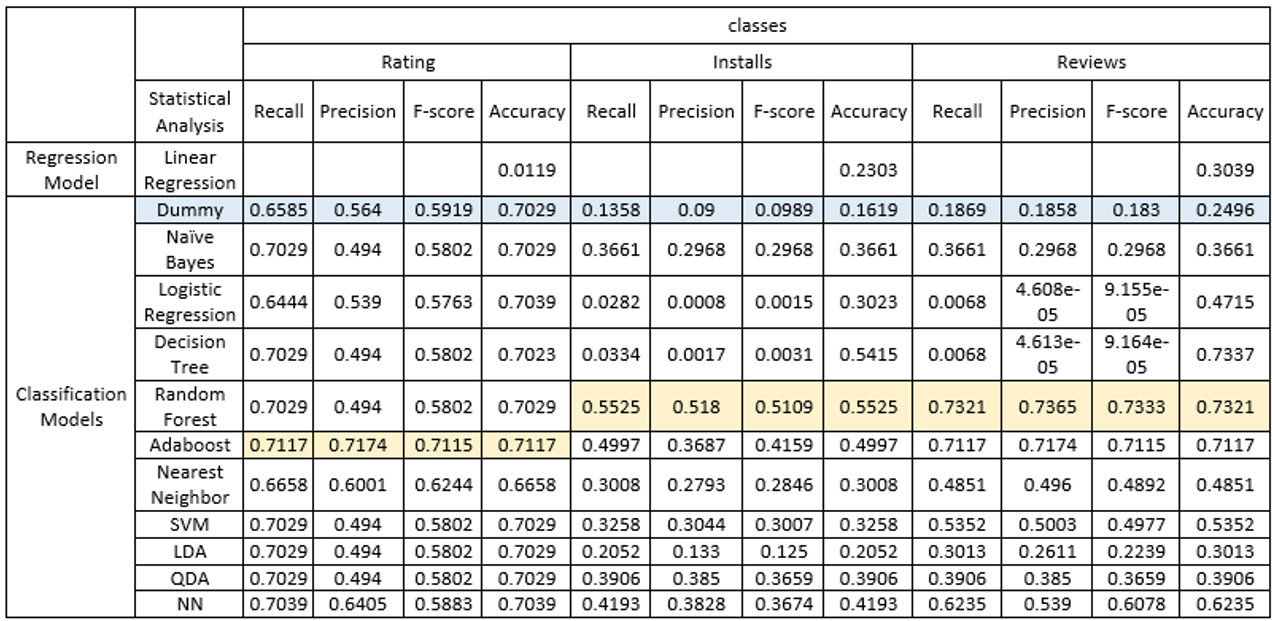

In [1]:
from IPython.display import Image
Image(filename='conclusion.jpg')

Although the decision tree classifier didn’t work well, the ensemble methods turned out to have great result. After comparing all the values, we think AdaBoost suits rating with highest outcome.  
  
Installs and reviews both have best results when using random forest classifier. We hope the result will help us analyze and understand the google market more easily in the future.